# Outliers and  Features

Here I compute all the time and control features other than topics (and emotions).



In [ ]:
%%capture
# Basics
!pip install emojis
!pip install textstat

import emojis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
plt.style.use("seaborn-paper")
import matplotlib.ticker as ticker


from textstat import flesch_reading_ease, smog_index

import re
from collections import Counter

In [ ]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_emotions_gpt.csv')

In [ ]:
df.shape

(2351, 26)

In [ ]:
# df for emoijs
df_emoij = df[(df['Total_emoijs'] > 200)]

In [ ]:
# to check whether I got the right data
Counter(df['emotion_gpt'])

Counter({'concern': 48,
         'determination': 681,
         'gratitude': 617,
         'neutral': 59,
         'pride': 366,
         'hope': 48,
         'optimism': 81,
         'patriotism': 50,
         'outrage': 168,
         'defiance': 185,
         'fear': 48})

## Outlier vis

I saw in the variable distributons that there are some high outliers driving results. Important otherwise estreme cases drive results. I inlcude the removal in the analysis section, as I run models inlcuding\excluding outliers as robustness checks.



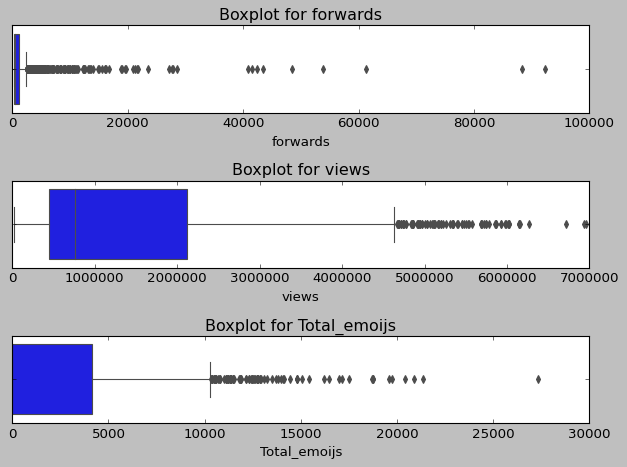

In [ ]:
# Visualise outliers
def outlier_views():
  fig, axs = plt.subplots(3)

  # Boxplot for 'forwards'
  sns.boxplot(x=df['forwards'], ax=axs[0])
  axs[0].set_title('Boxplot for forwards')

  # Boxplot for 'views'
  sns.boxplot(x=df['views'], ax=axs[1])
  axs[1].set_title('Boxplot for views')

  # Boxplot for 'Total_emoijs'
  sns.boxplot(x=df['Total_emoijs'], ax=axs[2])
  axs[2].set_title('Boxplot for Total_emoijs')

  # Show the plot
  plt.tight_layout()
  plt.show()

outlier_views()

__Emoijs need a df with low-number emoijs rows removed__



## Features

Idea behind all features is that they potentially can influence engagement:

- Len of text (characters, words, sentences)
- Average word length (a rough approximation for the complexity of the text)
    - Also include readability score (e.g. Flesch-Kincaid)
- Usage of punctuation (exclamation marks, questions mark can influence tone)
- Capitalisation (caps indicate emphasis)
- Presence of URL (affect engagement by providing further information)
- Presence of hashtags (indicate topic)
- Presence of emoijs (indicate tone or sentiment)
- Mentioning other users (look for Telegram mentions or links!)
- Media accompanying the message
- Presence of named entities (this goes in to the affective polarisation direction) [shoudl be related to the topic of texts]
- Call to actions (more likely to engage people)
- Time dummies

Features to think about:

- rolling average of messages

In [ ]:
# Convert 'date' to just dates without times and count the number of rows for each day
df.set_index(["date"], inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

Here I add a sentiment variable, based on the 10 dominant emotions.

In [ ]:
Counter(df['emotion_gpt'])

Counter({'pride': 366,
         'optimism': 81,
         'hope': 48,
         'defiance': 185,
         'neutral': 59,
         'outrage': 168,
         'patriotism': 50,
         'fear': 48,
         'determination': 681,
         'concern': 48,
         'gratitude': 617})

In [ ]:
pd.DataFrame(df[['message_final', 'emotion_gpt']])

,message_final,emotion_gpt
date,,
2022-02-24 04:42:52+00:00,We are Ukraine!,pride
2022-02-24 06:48:58+00:00,I will provide you with up-to-date and reliabl...,optimism
2022-02-24 15:35:31+00:00,Ukraine did not choose the path of war. But Uk...,hope
2022-02-24 21:26:30+00:00,I called on the leaders of the EU - participan...,optimism
2022-02-24 22:35:02+00:00,"Today, Russia attacked the entire territory of...",pride
...,...,...
2023-07-18 10:39:31+00:00,The number one issue at today's Stavka is mari...,neutral
2023-07-18 15:42:48+00:00,\n\nWar is evil. \nWar is tragedy.\nWar is a t...,determination
2023-07-18 17:31:58+00:00,I met with the President of the Japanese Inter...,gratitude


In [ ]:
# Sentiment variable
def assign_sentiment(emotion):
    if emotion in ['concern', 'outrage', 'fear']:
        return 'negative'
    if emotion == 'neutral':
        return 'neutral'
    else:
      return 'positive'

df['sentiment'] = df['emotion_gpt'].apply(assign_sentiment)
print(Counter(df['sentiment']))

Counter({'positive': 2028, 'negative': 264, 'neutral': 59})


In [ ]:
# Len of text
df['x_nchars'] = df['message_final'].apply(lambda x: len(x))

# Contains emoij
df['x_contains_emoij'] = df['message_final'].apply(lambda x: 1 if emojis.count(x) > 0 else 0)

# Time dummies
# Convert the 'DateColumn' to datetime type
#df['date'] = pd.to_datetime(df['date'])

# Create new columns for different components
df['x_year'] = df.index.year
df['x_month'] = df.index.month
df['x_weekofyear'] = df.index.strftime('%Y-%U')
df['x_monthofyear'] = df.index.strftime('%Y-%m')
df['x_day'] = df.index.day
df['x_weekday'] = df.index.weekday
df['x_hour'] = df.index.hour
df['x_weekofyear_cat'] = df['x_weekofyear'].astype('category').cat.codes
df['x_monthofyear_cat'] = df['x_monthofyear'].astype('category').cat.codes

# Affective polarisation
df['russia'] = df['message_final'].str.contains('terrorist|russia|aggressor',
                                                case=False).astype(int)

# Period of the day
df['x_periodofday'] = np.where((df['x_hour'] >= 0) & (df['x_hour'] < 6), 'Night',
                               np.where((df['x_hour'] >= 6) & (df['x_hour'] < 12), 'Morning',
                                        np.where((df['x_hour'] >= 12) & (df['x_hour'] < 18), 'Afternoon',
                                                 np.where((df['x_hour'] >= 18) & (df['x_hour'] < 22), 'Evening', 'Night'))))
df['x_periodofday'] = df['x_periodofday'].astype('category')



# Reading and complexity scores
df['flesch_reading_ease'] = df['message_final'].apply(flesch_reading_ease)
df['smog_index'] = df['message_final'].apply(smog_index)

# Log outcomes
df['log_views'] = np.log1p(df['views'])
df['log_forwards'] = np.log1p(df['forwards'])
df['log_Total_emoijs'] = np.log1p(df['Total_emoijs'])

# Descriptive Statistics

## Outcomes

### Distributions

In [ ]:
# Distributions of outcomes
def outcomes_dist(outcome: str, log = False, df = df):

    fig, ax = plt.subplots(figsize=(10, 6))

    if log:
      y = np.log1p(df[outcome])
      title = f'Histogram of log {outcome}'
    else:
      y = df[outcome]
      title = f'Histogram of {outcome}'
    ax.hist(y, bins=100, color='c', edgecolor='black')

    ax.set_title(title)
    ax.set_xlabel(f'{outcome}')
    ax.set_ylabel('Frequency')
    ax.ticklabel_format(useOffset=False, style='plain', axis='x') # to disable the offset
    ax.xaxis.set_major_formatter(ticker.EngFormatter())

    plt.show()

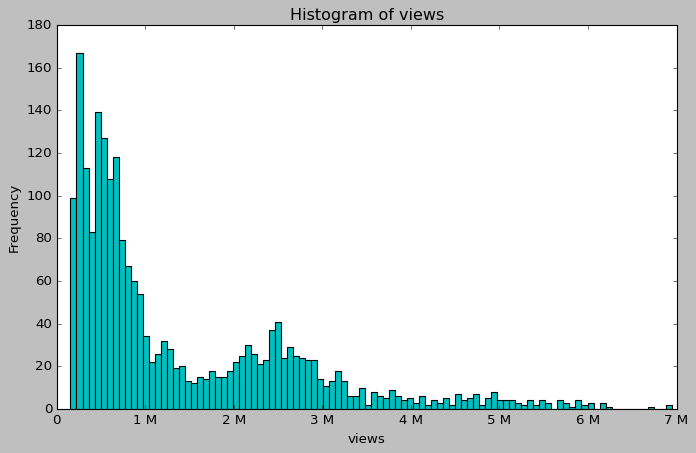

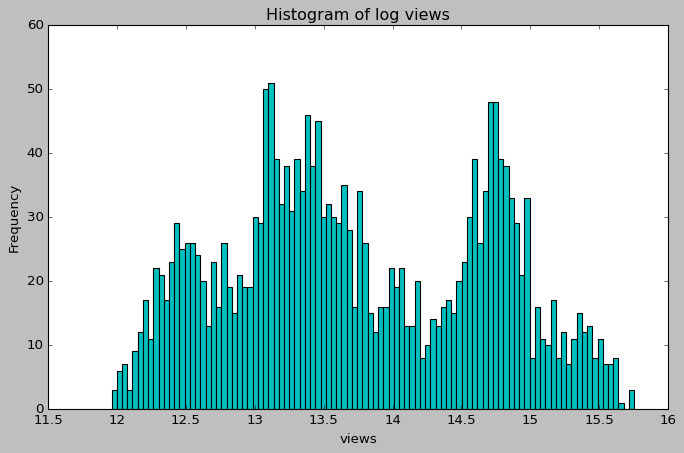

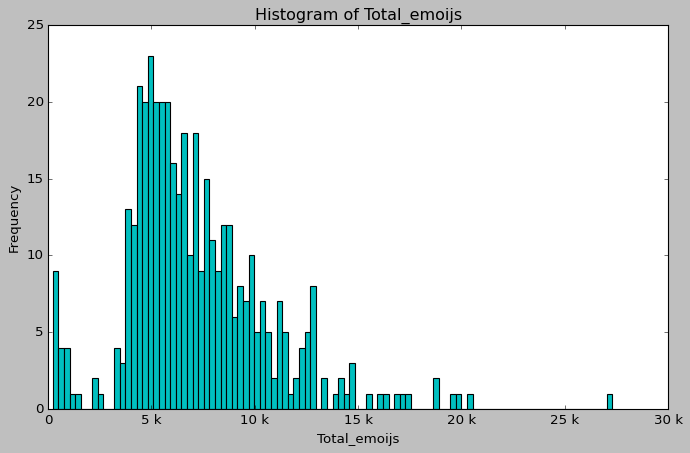

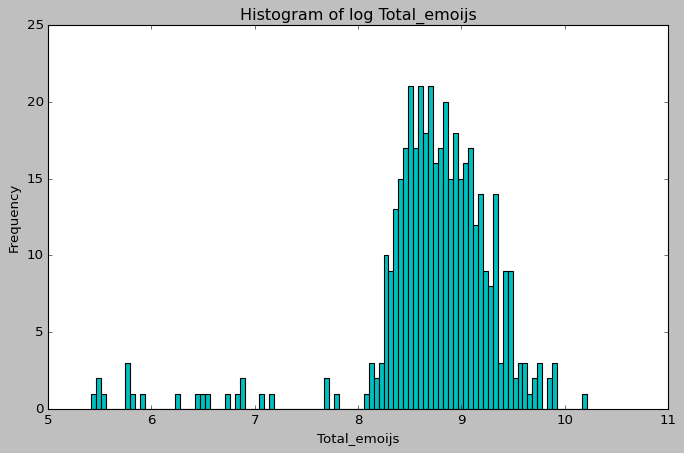

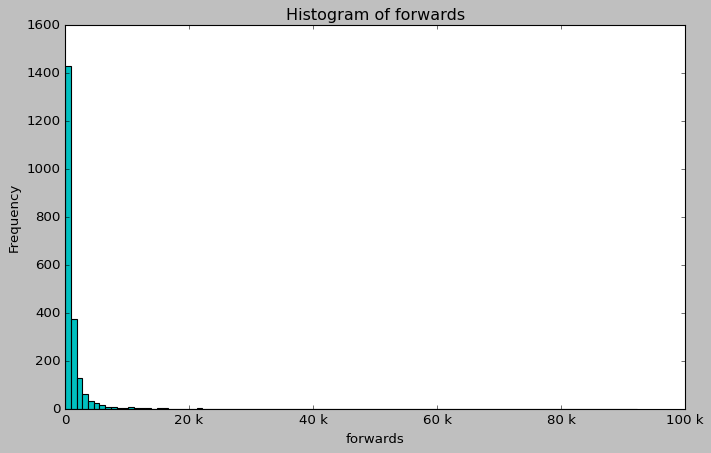

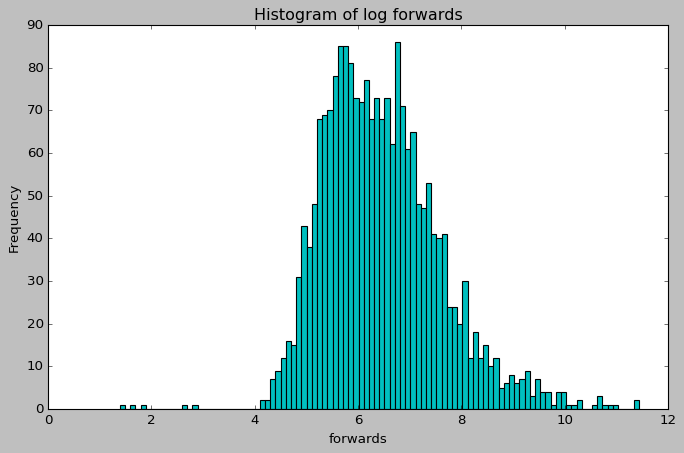

In [ ]:
outcomes_dist('views', log=False)
outcomes_dist('views', log=True)
outcomes_dist('Total_emoijs', log=False, df = df_emoij)
outcomes_dist('Total_emoijs', log=True, df = df_emoij)
outcomes_dist('forwards', log=False)
outcomes_dist('forwards', log=True)

__Implications__

- Total emoijs is $<200$ for 3/4 of the data
- Should I log transform variables? Sees only to help for forwards?



### Time Series

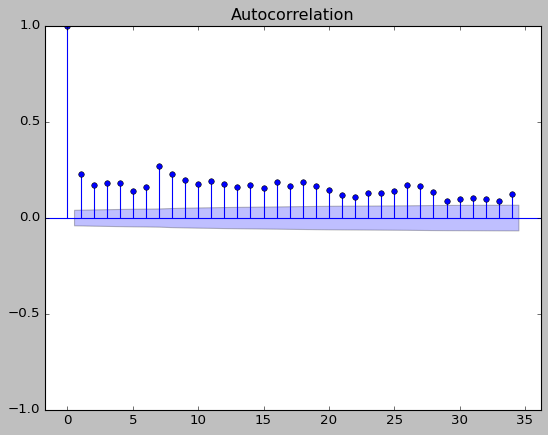

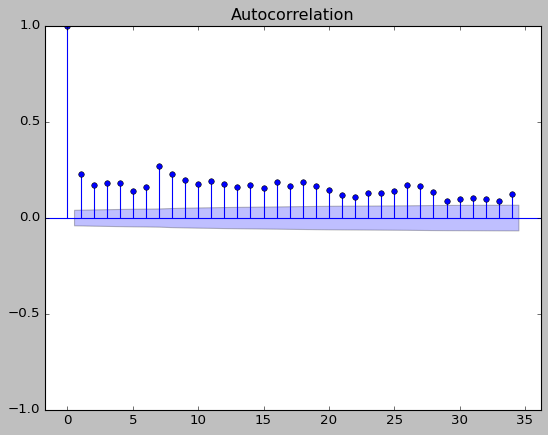

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Assuming you want to plot the autocorrelation of 'views' column
plot_acf(df['forwards'])

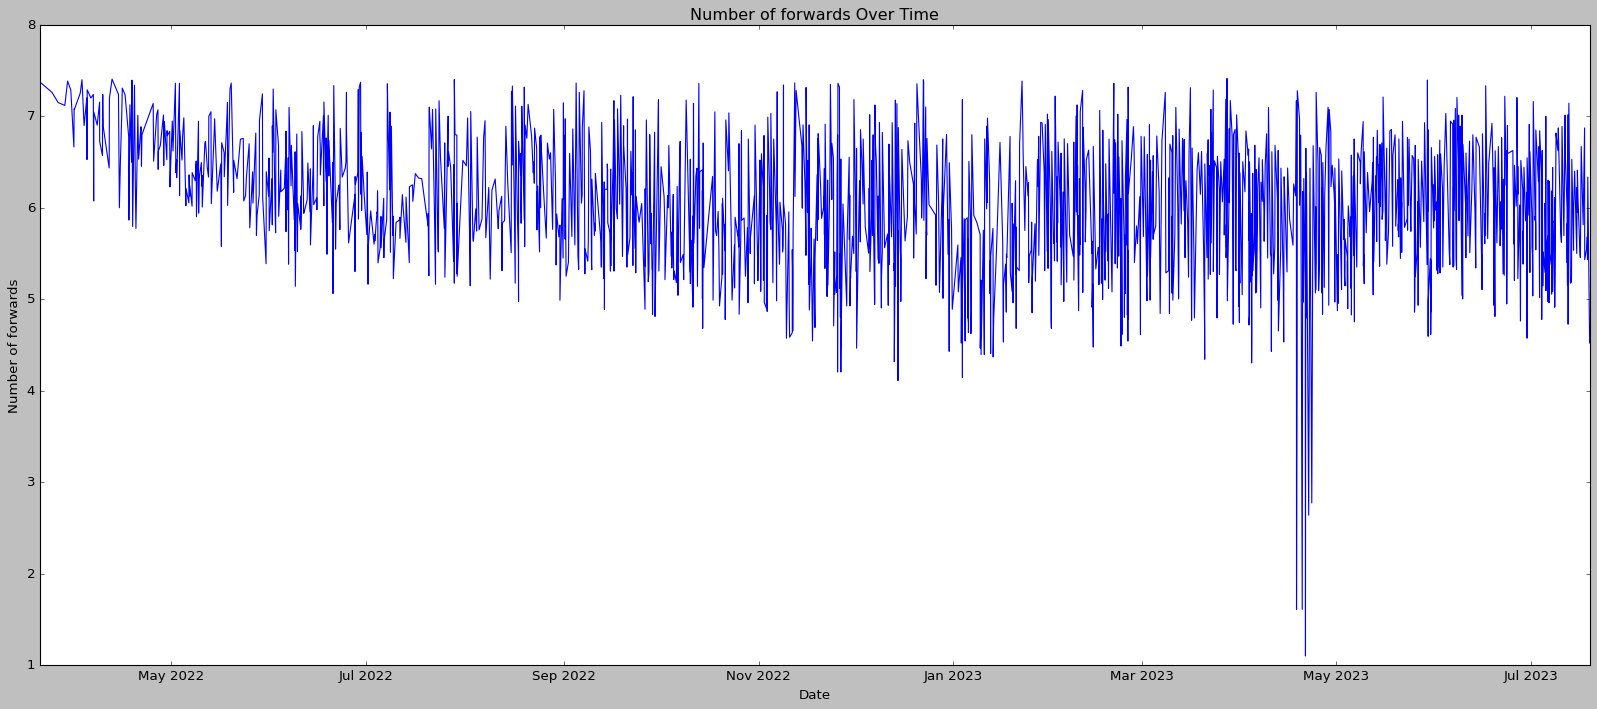

In [ ]:
def outcome_time(outcome, df=df):
  #df['date'] = pd.to_datetime(df['date'])  # convert the date column to datetime type
  df = df.sort_values('date')  # sort the data by date

  # plot the data
  plt.figure(figsize=(25, 10))
  plt.plot(df.index, np.log(df[outcome]))
  plt.xlabel('Date')
  plt.ylabel(f'Number of {outcome}')
  plt.title(f'Number of {outcome} Over Time')
  plt.show()

outcome_time(outcome='forwards')

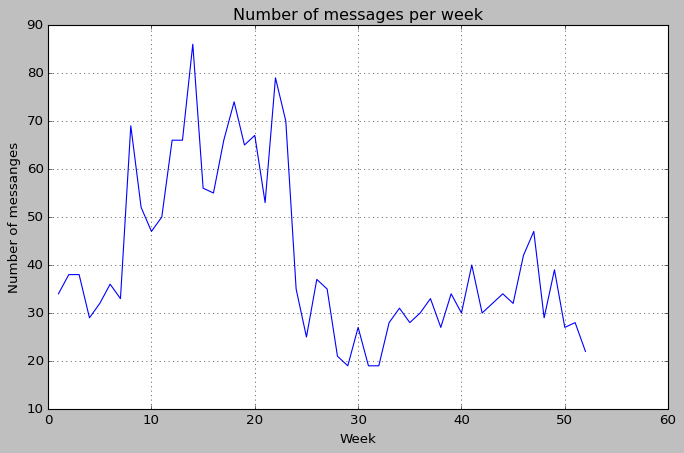

In [ ]:
def messages_over_time():

    # Count the number of rows per week
    weekly_counts = df.index.isocalendar().week.value_counts().sort_index()

    # Create the plot
    plt.figure(figsize=(10,6))
    weekly_counts.plot(kind='line')
    plt.title('Number of messages per week')
    plt.xlabel('Week')
    plt.ylabel('Number of messanges')
    plt.grid(True)
    plt.show()

messages_over_time()

## Emotions

In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'message', 'views', 'forwards',
       'reactions', 'mime_type', '😢', '🙏', '❤', '👍', 'Total_emoijs',
       'message_both', 'message_split_en', 'message_split_uk', 'message_lan',
       'message_score', 'en_original', 'uk_trans', 'message_final', 'topic',
       'emotion_gpt', 'sentiment', 'x_nchars', 'x_contains_emoij', 'x_year',
       'x_month', 'x_weekofyear', 'x_monthofyear', 'x_day', 'x_weekday',
       'x_hour', 'x_weekofyear_cat', 'x_monthofyear_cat', 'russia',
       'flesch_reading_ease', 'smog_index', 'log_views', 'log_forwards',
       'log_Total_emoijs'],
      dtype='object')

In [ ]:
def emotion_frequency(emotion_col):

    emotion_counts = df[emotion_col].value_counts()

    # Plot the frequency of each category
    plt.figure(figsize=(8, 6))
    plt.bar(emotion_counts.index, emotion_counts)
    plt.xlabel(f"Emotion {emotion_col}")
    plt.ylabel("Frequency")
    plt.title(f"Emotion {emotion_col} Frequency")
    plt.xticks(rotation=45)
    plt.show()


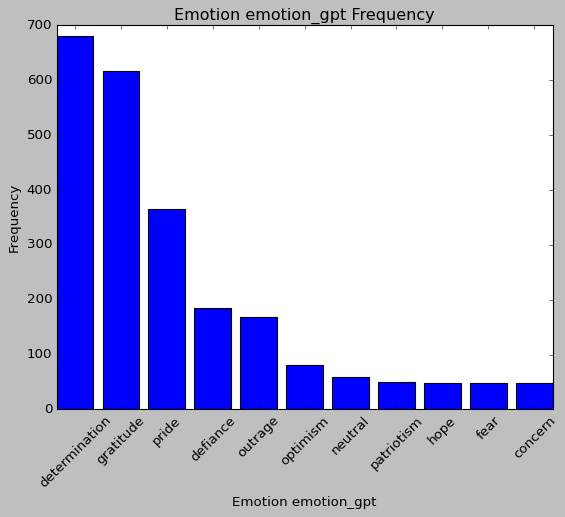

In [ ]:
emotion_frequency('emotion_gpt')

In [ ]:
# emotion_frequency('emotion_label_cardiff')
# emotion_frequency('emotion_label_hart')
# emotion_frequency('emotion_gpt')
# emotion_frequency('emotions_gpt_grouped')

In [ ]:
def outcome_by_emotion(emotion_col, outcome_col, df= df):

    # Calculate the average outcome by emotion
    average_outcome = df.groupby(emotion_col)[outcome_col].mean()

    # Plot the average outcome
    plt.figure(figsize=(8, 6))
    plt.bar(average_outcome.index, average_outcome)
    plt.xlabel(f"{emotion_col}")
    plt.ylabel(f"Average {outcome_col}")
    plt.title(f"Average {outcome_col} by {emotion_col}")
    plt.xticks(rotation=45)
    plt.show()

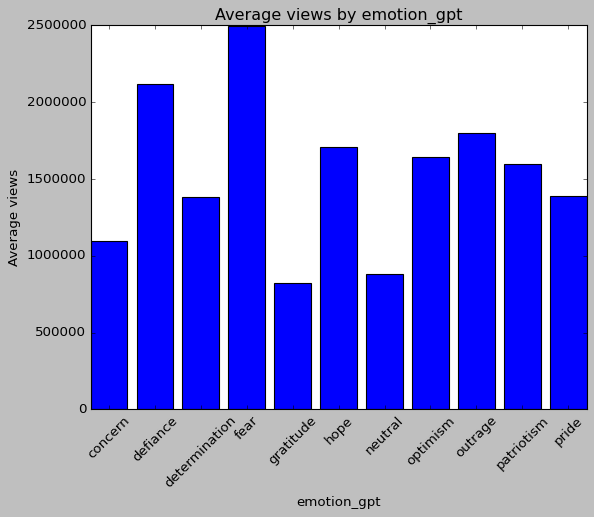

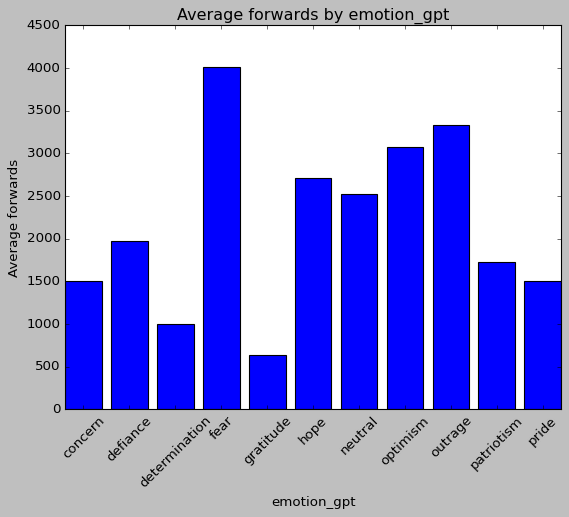

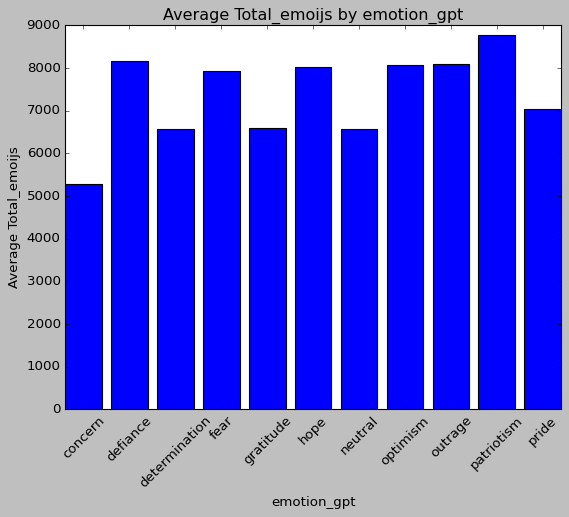

In [ ]:
outcome_by_emotion('emotion_gpt', 'views')
outcome_by_emotion('emotion_gpt', 'forwards')
outcome_by_emotion('emotion_gpt', 'Total_emoijs', df=df_emoij)

In [ ]:
# Call the function to plot the average outcome by emotion
# outcome_by_emotion('emotion_label_cardiff', 'views')
# outcome_by_emotion('emotion_label_cardiff', 'forwards')

# outcome_by_emotion('emotion_label_hart', 'views')
# outcome_by_emotion('emotion_label_hart', 'forwards')

# outcome_by_emotion('emotions_gpt_grouped', 'views')
# outcome_by_emotion('emotions_gpt_grouped', 'forwards')

In [ ]:
df.shape
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'message', 'views', 'forwards',
       'reactions', 'mime_type', '😢', '🙏', '❤', '👍', 'Total_emoijs',
       'message_both', 'message_split_en', 'message_split_uk', 'message_lan',
       'message_score', 'en_original', 'uk_trans', 'message_final', 'topic',
       'topic_no_outliers', 'emotion_gpt', 'sentiment', 'x_nchars',
       'x_contains_emoij', 'x_year', 'x_month', 'x_weekofyear',
       'x_monthofyear', 'x_day', 'x_weekday', 'x_hour', 'x_weekofyear_cat',
       'x_monthofyear_cat', 'russia', 'x_periodofday', 'flesch_reading_ease',
       'smog_index', 'log_views', 'log_forwards', 'log_Total_emoijs'],
      dtype='object')

## Example text of Emotions

In [ ]:
# Example text of Emotions
def example_messages(df):
  with pd.option_context("max_colwidth", None):

    # DF with definitions form oxford
    emotions_list = [
    ("determination", "The quality that makes you continue trying to do something even when this is difficult"),
    ("patriotism", "Love of your country and the desire to defend it"),
    ("hope", "To want something to happen and think that it is possible"),
    ("outrage", "A strong feeling of shock and anger"),
    ("optimism", "A feeling that good things will happen and that something will be successful"),
    ("gratitude", "The feeling of being grateful and wanting to express your thanks"),
    ("pride", "The pride of something a person or thing that makes people feel pleased or satisfied"),
    ("fear", "The bad feeling that you have when you are in danger or when a particular thing frightens you"),
    ("defiance", "The act of openly refusing to obey somebody/something"),
    ("concern", "To cause worry to someone"),
    ("neutral", "Deliberately not expressing any strong feeling")
    ]
    df_definitions = pd.DataFrame(emotions_list, columns=['Emotion', 'Definition Oxford'])

    # df for examples
    df_in = df.copy()
    df_in['text_length'] = df['message_final'].str.len()
    df_in = df_in[df_in['text_length'] >= 15]

    df_emo_text = df_in.groupby('emotion_gpt').apply(lambda x: x.nsmallest(3, 'text_length')).reset_index(drop=True)

    df_emo_text = df_emo_text[['emotion_gpt', 'message_final']]
    df_emo_text.columns = ['Emotion', 'Example Messgaes']

    # Merge dfs
    merged_df = pd.merge(df_emo_text, df_definitions, on='Emotion', how='left')
    merged_df = merged_df[['Emotion', 'Definition Oxford', 'Example Messgaes']]

    merged_df_tex = merged_df.to_latex(index=False)
    merged_df_tex = merged_df_tex.replace('\\begin{tabular}{lll}\n', '\\begin{tabularx}{lcX}\n')
    merged_df_tex = merged_df_tex.replace('\\end{tabular}\n', '\\end{tabular}\n')

    merged_df_tex = merged_df_tex.replace('\\toprule\n', '\\toprule\\toprule\n')
    merged_df_tex = merged_df_tex.replace('\\bottomrule\n', '\\bottomrule\\bottomrule\n')

  print(merged_df_tex)
  return None


In [ ]:
example_messages(df)

\begin{tabularx}{lcX}
\toprule\toprule
      Emotion &                                                                             Definition Oxford &                                                                                                                                                                                                                                 Example Messgaes \\
\midrule
      concern &                                                                     To cause worry to someone &                                                                                                      CNN Interview about Russia's crimes, support from other countries, and the battle in Donbas that could impact the course of the entire war. \\
      concern &                                                                     To cause worry to someone &                 The conversation with Alexander Lukashenko was very substantive. I do not want missiles, planes, and helicopters

<ipython-input-41-e32d27d4cdc0>:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  merged_df_tex = merged_df.to_latex(index=False)


In [ ]:
!pip install demoji
import demoji

  Using cached demoji-1.1.0-py3-none-any.whl (42 kB)


In [ ]:
def example_messages(df):
    with pd.option_context("max_colwidth", None):
        # DF with definitions form oxford
        emotions_list = [
            ("determination", "The quality that makes you continue trying to do something even when this is difficult"),
            ("patriotism", "Love of your country and the desire to defend it"),
            ("hope", "To want something to happen and think that it is possible"),
            ("outrage", "A strong feeling of shock and anger"),
            ("optimism", "A feeling that good things will happen and that something will be successful"),
            ("gratitude", "The feeling of being grateful and wanting to express your thanks"),
            ("pride", "The pride of something a person or thing that makes people feel pleased or satisfied"),
            ("fear", "The bad feeling that you have when you are in danger or when a particular thing frightens you"),
            ("defiance", "The act of openly refusing to obey somebody/something"),
            ("concern", "To cause worry to someone"),
            ("neutral", "Deliberately not expressing any strong feeling")
        ]
        df_definitions = pd.DataFrame(emotions_list, columns=['Emotion', 'Definition Oxford'])

        # df for examples
        df_in = df.copy()
        df_in['text_length'] = df['message_final'].str.len()
        df_in = df_in[df_in['text_length'] >= 15]

        df_emo_text = df_in.groupby('emotion_gpt').apply(lambda x: x.nsmallest(3, 'text_length')).reset_index(drop=True)
        df_emo_text = df_emo_text[['emotion_gpt', 'message_final']]
        df_emo_text.columns = ['Emotion', 'Example Messages']
        df_emo_text['Example Messages'] = df_emo_text['Example Messages'].apply(lambda x: demoji.replace(x, ""))

        # Merge and join messages with '\\\\' as separator
        merged_df = df_emo_text.groupby('Emotion')['Example Messages'].apply(' \\n'.join).reset_index()
        merged_df = pd.merge(merged_df, df_definitions, on='Emotion', how='left')
        merged_df = merged_df[['Emotion', 'Definition Oxford', 'Example Messages']]

        merged_df_tex = merged_df.to_latex(index=False, escape=False)
        merged_df_tex = merged_df_tex.replace('\\begin{tabular}{lll}\n', '\\begin{tabularx}{lXX}\n')
        merged_df_tex = merged_df_tex.replace('\\end{tabular}\n', '\\end{tabularx}\n')

        merged_df_tex = merged_df_tex.replace('\\toprule\n', '\\toprule\\toprule\n')
        merged_df_tex = merged_df_tex.replace('\\bottomrule\n', '\\bottomrule\\bottomrule\n')
    with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/emotions_examples.tex', 'w') as file:
      file.write(merged_df_tex)
    print(merged_df_tex)
    return None


In [ ]:
example_messages(df)

\begin{tabularx}{lXX}
\toprule\toprule
      Emotion &                                                                             Definition Oxford &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Example Messages \\
\midrule
      concern &                                                                     To cause worry to someone & CNN Interview about Russia's crimes, support from other countries, and the battle in Donbas that could impact the c

<ipython-input-65-51a81d257f22>:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  merged_df_tex = merged_df.to_latex(index=False, escape=False)


# Out


In [ ]:
# Save data
# Load data
df.to_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/df_final.csv')